In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import operator
import datetime
import pickle
from time import gmtime, strftime 
from tqdm.notebook import trange, tqdm
import statistics

In [3]:
# functions
def degree_info(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    dmax = max(degree_sequence)
    value, counts = np.unique(degree_sequence, return_counts=True)
    CC = sorted(nx.connected_components(G), key = len, reverse=True) #sort by len, the first element is the giant component
    gcc = len(CC[0])/float(len(G.nodes()))
    return (G.subgraph(CC[0]), statistics.mean(degree_sequence), 100*gcc)

def get_states_from_nodes(df, nodes):
    return dict(df[df['user_id'].isin(nodes)]["state"].value_counts())
       
def get_west_from_nodes(df, nodes):
    return dict(df[df['user_id'].isin(nodes)]["west"].value_counts())
        

In [5]:
df_IKEA_users_wth_friends = pd.read_pickle("df_IKEA_users_wth_friends.pkl")

In [8]:
states = list(set(df_IKEA_users_wth_friends["state"].unique())) + ["ALL"]
states

['MA', 'OH', 'FL', 'GA', 'BC', 'VA', 'OR', 'ALL']

In [9]:
df_states = []
for state in states:
    lines = []
    outsiders = 0
    friends = 0
    state_users = set((df_IKEA_users_wth_friends.query('state == "{}"'.format(state))
                     .filter(['user_id'])).values.flatten())
    for index, row in df_IKEA_users_wth_friends.iterrows():
        for friend in row['friends'].split(","):
            if row["state"] == state:
                line = "{} {}".format(row["user_id"], friend)
                lines.append(line)
                friends += 1
                if friend not in state_users:
                    outsiders += 1
            elif state == "ALL":
                line = "{} {}".format(row["user_id"], friend)
                lines.append(line)
                friends += 1
    G = nx.parse_edgelist(lines)
    (GiantC, avg_degree, perc_gcc) = degree_info(G)
    df_states.append({"state": state,
                      "avg_degree" : avg_degree,
                      "perc_gcc": perc_gcc,
                      "edges": nx.number_of_edges(G),
                      "nodes": nx.number_of_nodes(G),
                      "transitivity": nx.transitivity(G), # the fraction of all possible triangles present in G.
                      "average_clustering": nx.average_clustering(G), # average clustering coefficient for the graph
                      "average_shortest_path_GC": nx.average_shortest_path_length(GiantC), 
                      "assortativity": nx.degree_assortativity_coefficient(G),
                      "outsider_friendships": outsiders, # friends from others states
                      "friendships": friends
                     })
    
df_states = pd.DataFrame(df_states)
df_states

,state,avg_degree,perc_gcc,edges,nodes,transitivity,average_clustering,average_shortest_path_GC,assortativity,outsider_friendships,friendships
0,MA,6.329571,98.645598,1402,443,0.129132,0.234970,3.017561,-0.170801,306,2498
1,OH,4.341232,100.000000,458,211,0.093584,0.337374,2.501061,-0.475013,170,746
2,FL,9.100000,99.615385,2366,520,0.202849,0.354061,2.831617,-0.331114,613,4119
3,GA,9.931777,98.025135,2766,557,0.261351,0.290781,2.973815,-0.214499,575,4957
4,BC,7.777778,99.305556,1120,288,0.219885,0.315618,2.804417,-0.320016,200,2040
5,VA,4.319527,98.816568,365,169,0.140507,0.227760,2.694611,-0.541086,200,530
6,OR,6.985294,96.078431,1425,408,0.196946,0.277827,2.962133,-0.237391,336,2514
7,ALL,11.571809,98.537234,8702,1504,0.215305,0.396090,3.296666,-0.169191,0,17404


<AxesSubplot:xlabel='state'>

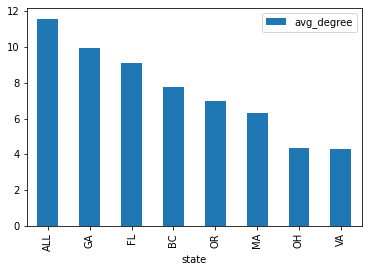

In [39]:
df_states.sort_values(["avg_degree"], ascending=False).plot(x='state', y='avg_degree', kind="bar")

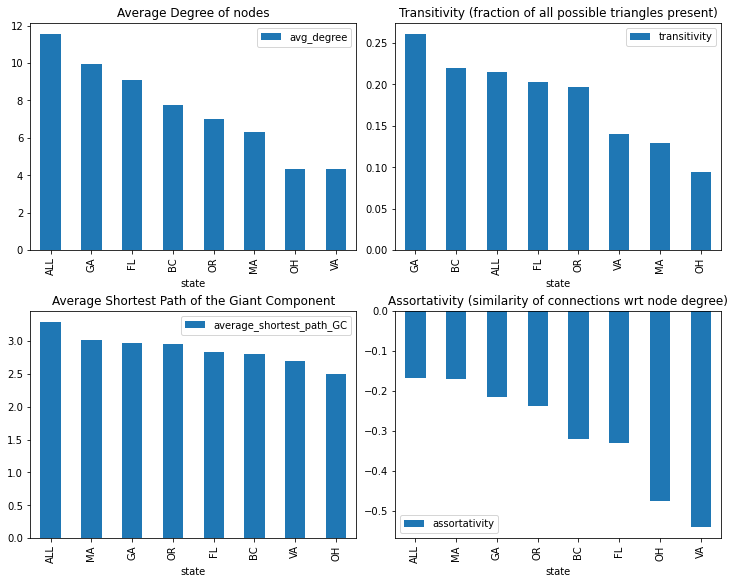

In [54]:
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2)

ax0 = fig.add_subplot(spec[0, 0])
df_states.sort_values(["avg_degree"], ascending=False).plot(x='state', y='avg_degree', kind="bar", ax=ax0)
ax0.set_title("Average Degree of nodes")

ax1 = fig.add_subplot(spec[0, 1])
df_states.sort_values(["transitivity"], ascending=False).plot(x='state', y='transitivity', kind="bar", ax=ax1)
ax1.set_title("Transitivity (fraction of all possible triangles present)")

ax2 = fig.add_subplot(spec[1, 0])
df_states.sort_values(["average_shortest_path_GC"], ascending=False).plot(x='state', y='average_shortest_path_GC', kind="bar", ax=ax2)
ax2.set_title("Average Shortest Path of the Giant Component")

ax3 = fig.add_subplot(spec[1, 1])
df_states.sort_values(["assortativity"], ascending=False).plot(x='state', y='assortativity', kind="bar", ax=ax3)
ax3.set_title("Assortativity (similarity of connections wrt node degree)");



# Powerlaw

In [6]:
import powerlaw
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
dmax = max(degree_sequence)
value, counts = np.unique(degree_sequence, return_counts=True)
fit = powerlaw.Fit(counts)
print("alpha", fit.power_law.alpha)
print("xmin", fit.power_law.xmin)
print("signma", fit.power_law.sigma)

Calculating best minimal value for power law fit
alpha 1.7455240062565691
xmin 3.0
signma 0.10338557814028446


Text(0.5, 1.0, 'probability density function of counts')

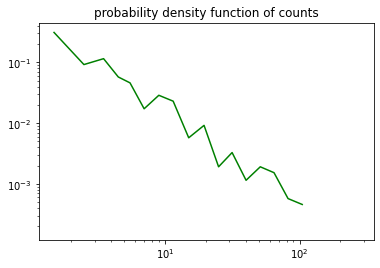

In [55]:
fig, ax = plt.subplots();
powerlaw.plot_pdf(counts, color="g", ax=ax)
ax.set_title("probability density function of counts")

In [8]:
R, p = fit.distribution_compare("power_law","lognormal", normalized_ratio=True)
print(R,p)

-0.4805278150381258 0.6308521297584047


In [9]:
# https://github.com/jeffalstott/powerlaw
R, p = fit.distribution_compare("power_law","lognormal_positive", normalized_ratio=True)
print(R,p)

0.17054809246036937 0.8645791159977594


In [10]:
R, p = fit.distribution_compare("power_law","exponential", normalized_ratio=True)
print(R,p)

2.7356739346390735 0.006225267702259666


# Rich Club

For each degree k, the rich-club coefficient is the ratio of the number of actual to the number of potential edges for nodes with degree greater than k:

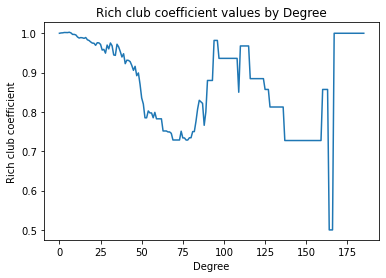

In [85]:
rc_G = nx.rich_club_coefficient(G, Q=dmax, normalized=True)
fig, ax = plt.subplots()
plt.title("Rich club coefficient values by Degree")
plt.ylabel("Rich club coefficient")
plt.xlabel("Degree")
plt.plot(rc_G.keys(),rc_G.values())

no rich-club effect.

no hierarchical structure in this network

# Community detection  using Girvan–Newman method.


In [111]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
import itertools
import time

# using Giant Component
# G = nx.karate_club_graph()
# communities = girvan_newman(G)
communities = girvan_newman(GiantC)


save_communities = {}
k = 6 # because we have 7 states 
splits = 2
start = time.time()
for com in itertools.islice(communities, k):
    save_communities[splits] = com
    print("splits", splits, "done in", round(time.time() - start, 2), "seconds")
    splits += 1
# with open("save_communities.pkl", "wb") as pf:
#     pickle.dump(save_communities, pf)
    
# splits 2 done in 3788.9 seconds
# splits 3 done in 5099.97 seconds
# splits 4 done in 6145.51 seconds
# splits 5 done in 6575.19 seconds
# splits 6 done in 6761.96 seconds
# splits 7 done in 6765.92 seconds

splits 2 done in 3788.9 seconds
splits 3 done in 5099.97 seconds
splits 4 done in 6145.51 seconds
splits 5 done in 6575.19 seconds
splits 6 done in 6761.96 seconds
splits 7 done in 6765.92 seconds


splits 2
length com 2
1304 blue {'GA': 332, 'MA': 293, 'FL': 271, 'OR': 254, 'OH': 103, 'VA': 47, 'BC': 4} in the west ? {False: 1046, True: 258}
178 green {'BC': 171, 'OR': 5, 'GA': 2} in the west ? {True: 176, False: 2}
modularity 0.18547764268933936


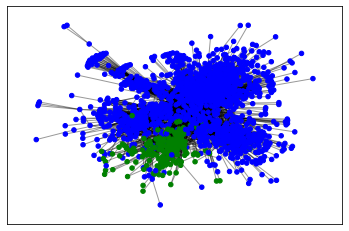

splits 3
length com 3
1063 blue {'GA': 332, 'MA': 290, 'FL': 271, 'OH': 102, 'VA': 47, 'OR': 19, 'BC': 2} in the west ? {False: 1042, True: 21}
178 green {'BC': 171, 'OR': 5, 'GA': 2} in the west ? {True: 176, False: 2}
241 red {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} in the west ? {True: 237, False: 4}
modularity 0.3697724721570822


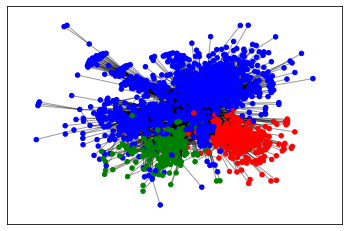

splits 4
length com 4
285 blue {'MA': 272, 'GA': 4, 'OR': 4, 'FL': 3, 'BC': 2} in the west ? {False: 279, True: 6}
778 green {'GA': 328, 'FL': 268, 'OH': 102, 'VA': 47, 'MA': 18, 'OR': 15} in the west ? {False: 763, True: 15}
178 red {'BC': 171, 'OR': 5, 'GA': 2} in the west ? {True: 176, False: 2}
241 yellow {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} in the west ? {True: 237, False: 4}
modularity 0.5169992827419141


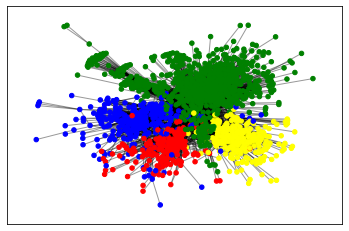

splits 5
length com 5
285 blue {'MA': 272, 'GA': 4, 'OR': 4, 'FL': 3, 'BC': 2} in the west ? {False: 279, True: 6}
663 green {'GA': 322, 'FL': 263, 'VA': 46, 'MA': 15, 'OR': 14, 'OH': 3} in the west ? {False: 649, True: 14}
178 red {'BC': 171, 'OR': 5, 'GA': 2} in the west ? {True: 176, False: 2}
241 yellow {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} in the west ? {True: 237, False: 4}
115 pink {'OH': 99, 'GA': 6, 'FL': 5, 'MA': 3, 'VA': 1, 'OR': 1} in the west ? {False: 114, True: 1}
modularity 0.5544311866151118


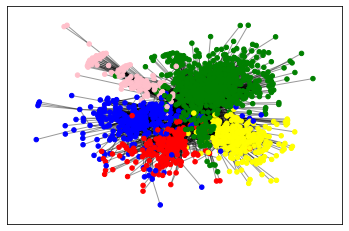

splits 6
length com 6
285 blue {'MA': 272, 'GA': 4, 'OR': 4, 'FL': 3, 'BC': 2} in the west ? {False: 279, True: 6}
661 green {'GA': 320, 'FL': 263, 'VA': 46, 'MA': 15, 'OR': 14, 'OH': 3} in the west ? {False: 647, True: 14}
178 red {'BC': 171, 'OR': 5, 'GA': 2} in the west ? {True: 176, False: 2}
241 yellow {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} in the west ? {True: 237, False: 4}
115 pink {'OH': 99, 'GA': 6, 'FL': 5, 'MA': 3, 'VA': 1, 'OR': 1} in the west ? {False: 114, True: 1}
2 cyan {'GA': 2} in the west ? {False: 2}
modularity 0.5545102641304193


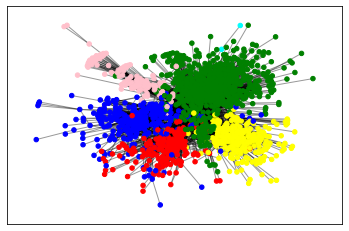

splits 7
length com 7
285 blue {'MA': 272, 'GA': 4, 'OR': 4, 'FL': 3, 'BC': 2} in the west ? {False: 279, True: 6}
659 green {'GA': 318, 'FL': 263, 'VA': 46, 'MA': 15, 'OR': 14, 'OH': 3} in the west ? {False: 645, True: 14}
178 red {'BC': 171, 'OR': 5, 'GA': 2} in the west ? {True: 176, False: 2}
241 yellow {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} in the west ? {True: 237, False: 4}
115 pink {'OH': 99, 'GA': 6, 'FL': 5, 'MA': 3, 'VA': 1, 'OR': 1} in the west ? {False: 114, True: 1}
2 cyan {'GA': 2} in the west ? {False: 2}
2 magenta {'GA': 2} in the west ? {False: 2}
modularity 0.5545892820694971


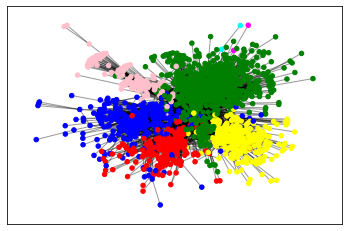

In [22]:
import networkx.algorithms.community as nx_comm
community_splits = []
community_modularities = []

with open("save_communities.pkl", "rb") as pf:
    save_communities = pickle.load(pf)
    colours = ['blue', 'green', 'red', 'yellow', 'pink', 'cyan', 'magenta', 'black']
    for splits,com in save_communities.items():
        print("splits",splits)
        print("length com", len(com))
        community_splits.append(len(com))
        color_map = []
        nodes = com[0]
        for node in GiantC:
            if node in com[0]:
                color_map.append(colours[0])
            elif node in com[1]: 
                color_map.append(colours[1])  
            elif node in com[2]: 
                color_map.append(colours[2]) 
            elif node in com[3]: 
                color_map.append(colours[3]) 
            elif node in com[4]: 
                color_map.append(colours[4]) 
            elif node in com[5]: 
                color_map.append(colours[5]) 
            elif node in com[6]: 
                color_map.append(colours[6]) 
            else:
                color_map.append(colours[7]) 
#         nx.draw(GiantC, node_color=color_map, with_labels=False, pos=nx.spring_layout(GiantC))
        for i in range(len(com)):
            print(len(com[i]), 
                  colours[i], 
                  get_states_from_nodes(df=df_IKEA_users_wth_friends, nodes=com[i]),
                  "in the west ?", get_west_from_nodes(df=df_IKEA_users_wth_friends, nodes=com[i]))
        modularity = nx_comm.modularity(GiantC, com)
        print("modularity",modularity)
        community_modularities.append(modularity)
        pos = nx.spring_layout(GiantC, seed=10396953)
        nx.draw_networkx_nodes(GiantC, pos, node_color=color_map, node_size=20)
        nx.draw_networkx_edges(GiantC, pos, alpha=0.4)
        plt.show()


splits 2
length com 2
1304 blue {'GA': 332, 'MA': 293, 'FL': 271, 'OR': 254, 'OH': 103, 'VA': 47, 'BC': 4} {False: 1046, True: 258}
178 green {'BC': 171, 'OR': 5, 'GA': 2} {True: 176, False: 2}
modularity 0.18547764268933936


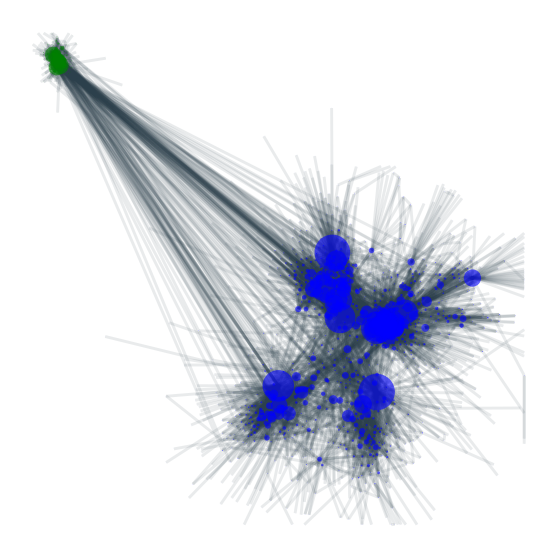

splits 3
length com 3
1063 blue {'GA': 332, 'MA': 290, 'FL': 271, 'OH': 102, 'VA': 47, 'OR': 19, 'BC': 2} {False: 1042, True: 21}
178 green {'BC': 171, 'OR': 5, 'GA': 2} {True: 176, False: 2}
241 red {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} {True: 237, False: 4}
modularity 0.3697724721570822


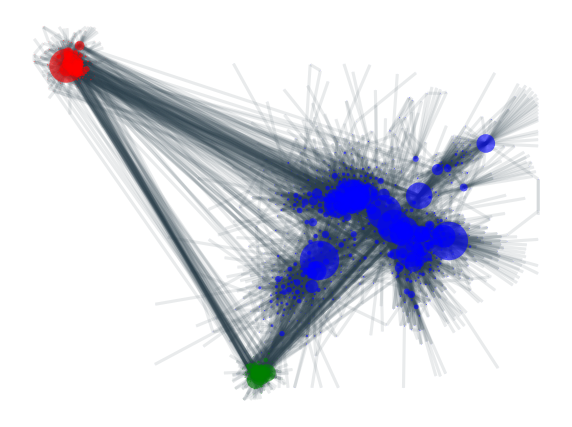

splits 4
length com 4
285 blue {'MA': 272, 'GA': 4, 'OR': 4, 'FL': 3, 'BC': 2} {False: 279, True: 6}
778 green {'GA': 328, 'FL': 268, 'OH': 102, 'VA': 47, 'MA': 18, 'OR': 15} {False: 763, True: 15}
178 red {'BC': 171, 'OR': 5, 'GA': 2} {True: 176, False: 2}
241 yellow {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} {True: 237, False: 4}
modularity 0.5169992827419141


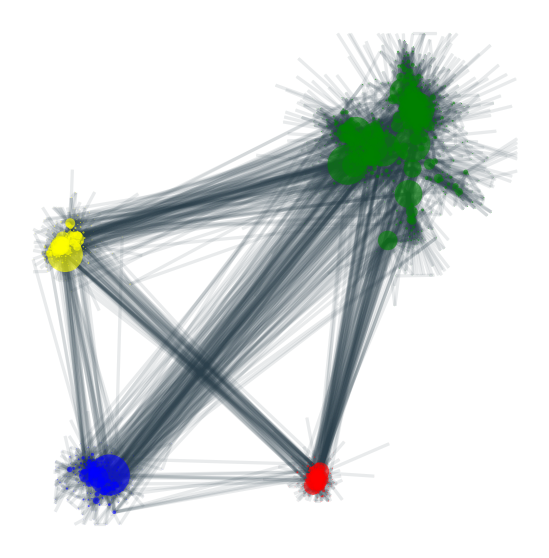

splits 5
length com 5
285 blue {'MA': 272, 'GA': 4, 'OR': 4, 'FL': 3, 'BC': 2} {False: 279, True: 6}
663 green {'GA': 322, 'FL': 263, 'VA': 46, 'MA': 15, 'OR': 14, 'OH': 3} {False: 649, True: 14}
178 red {'BC': 171, 'OR': 5, 'GA': 2} {True: 176, False: 2}
241 yellow {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} {True: 237, False: 4}
115 pink {'OH': 99, 'GA': 6, 'FL': 5, 'MA': 3, 'VA': 1, 'OR': 1} {False: 114, True: 1}
modularity 0.5544311866151118


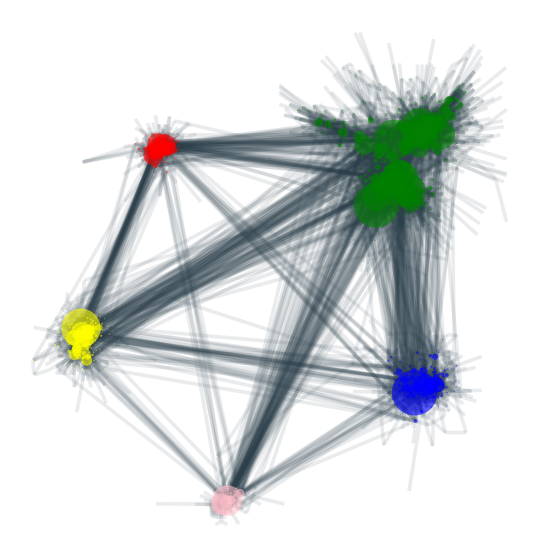

splits 6
length com 6
285 blue {'MA': 272, 'GA': 4, 'OR': 4, 'FL': 3, 'BC': 2} {False: 279, True: 6}
661 green {'GA': 320, 'FL': 263, 'VA': 46, 'MA': 15, 'OR': 14, 'OH': 3} {False: 647, True: 14}
178 red {'BC': 171, 'OR': 5, 'GA': 2} {True: 176, False: 2}
241 yellow {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} {True: 237, False: 4}
115 pink {'OH': 99, 'GA': 6, 'FL': 5, 'MA': 3, 'VA': 1, 'OR': 1} {False: 114, True: 1}
2 cyan {'GA': 2} {False: 2}
modularity 0.5545102641304193


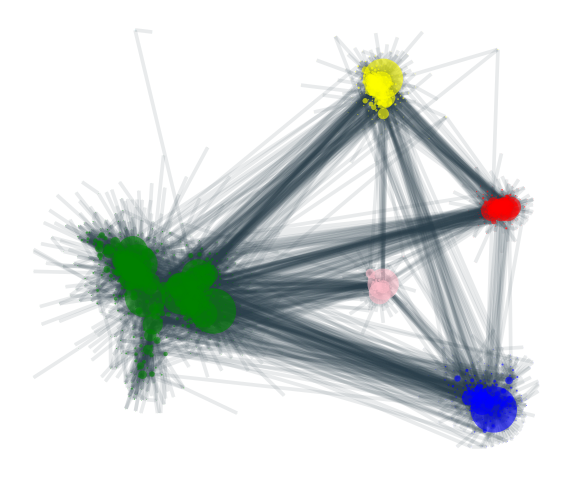

splits 7
length com 7
285 blue {'MA': 272, 'GA': 4, 'OR': 4, 'FL': 3, 'BC': 2} {False: 279, True: 6}
659 green {'GA': 318, 'FL': 263, 'VA': 46, 'MA': 15, 'OR': 14, 'OH': 3} {False: 645, True: 14}
178 red {'BC': 171, 'OR': 5, 'GA': 2} {True: 176, False: 2}
241 yellow {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} {True: 237, False: 4}
115 pink {'OH': 99, 'GA': 6, 'FL': 5, 'MA': 3, 'VA': 1, 'OR': 1} {False: 114, True: 1}
2 cyan {'GA': 2} {False: 2}
2 magenta {'GA': 2} {False: 2}
modularity 0.5545892820694971


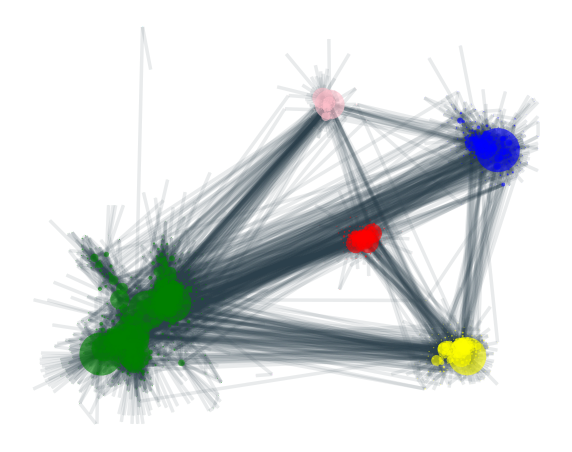

In [22]:
import networkx.algorithms.community as nx_comm
from netgraph import Graph

community_splits = []
community_modularities = []
with open("save_communities.pkl", "rb") as pf:
    save_communities = pickle.load(pf)
    colours = ['blue', 'green', 'red', 'yellow', 'pink', 'cyan', 'magenta', 'black']
    for splits, com in save_communities.items():
        print("splits",splits)
        print("length com", len(com))
        community_splits.append(len(com))
        node_to_community = dict()
        for community_id in range(len(com)):
            for node in com[community_id]:
                node_to_community[node] = community_id
            print(len(com[community_id]), 
                  colours[community_id], 
                  get_states_from_nodes(df=df_IKEA_users_wth_friends, nodes=com[community_id]),
                  get_west_from_nodes(df=df_IKEA_users_wth_friends, nodes=com[community_id])) 
        modularity = nx_comm.modularity(GiantC, com)
        print("modularity",modularity)
        community_modularities.append(modularity)
        community_to_color = dict(zip(list(range(7)), colours))

        node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}
        plt.figure(splits, figsize=(10,10)) 
        Graph(GiantC,node_size={k:v/30 for k,v in dict(nx.degree(GiantC)).items()},node_alpha=0.6,
              node_color=node_color, node_edge_width=0, edge_alpha=0.1,
              node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
#               edge_layout='bundled', edge_layout_kwargs=dict(k=2000), # takes too long :( 
        )
        plt.show()
 

In [20]:
{k:v/20 for k,v in dict(nx.degree(GiantC)).items()}

{'fxqvyXlml4400BglsxRG_w': 0.55,
 'PQOHkTVWUoAxAkiUa3SRMg': 1.35,
 't903_es-gp3abvdrIQutQA': 4.7,
 'E3xpr996watZyp6P0587Ow': 0.6,
 'BQM8240Ekmsltf_o1CB6fg': 0.15,
 'Q_6Eu90uTD5i0hCJ3Mi7Wg': 1.2,
 'MtHD0Wdh4FtbyFJCb4yfUQ': 1.75,
 'Q3DkgHMlBOi320AWRemtdg': 1.25,
 'rcU7ysY41qGppbw4pQgjqg': 9.5,
 'gbx3IYFKB-36HhV5wM3G1w': 2.4,
 'FvOntEHaOIfxk0klEkyixQ': 1.15,
 'xRBnIhqYTJZcEA4-wuZ4uA': 0.75,
 'npD9KeIpB7PX3OwBMxZ3EQ': 1.65,
 'MC3Qx8xGjgB43mEQKpldMg': 0.85,
 '5Th9zs60z2V8eZFnk3lF3A': 2.1,
 '-xmgxdGoS8kIqAzGOb1XXw': 0.5,
 '-WOYs7OOU3xqdQXJRz9_cg': 1.25,
 'PbAG86c07f7cQqFsgaT_cg': 0.9,
 'g8j2ci2FcvmocszcO6ypNw': 4.25,
 '5AyaCHkJaeMLmjzu-NwZyQ': 2.75,
 'k_TavHq78rXiNcv81M7Fog': 0.9,
 'pbLzfhrxTWuhmBpGzo0eEQ': 0.4,
 '8ex-daYAdef5u9NtdbSr6Q': 0.65,
 'hcCFyJJt3OLV1OtPlQeDoA': 1.6,
 'QjZ3eGdAo-wlUJJna9GyWA': 1.0,
 'ZsTZg-R5QPCkBgyE0MyktQ': 0.95,
 '0G-bcpdR48tfZy6koGUiTQ': 5.8,
 'eYd1sygl0Thd2JRQTVgX5A': 8.0,
 '6p8TDejFzwL4Z2QSl2_IGA': 2.55,
 'IyIsFkVY48JWa01inv-7zA': 3.95,
 'oXBhr-GbxjceT-g1UjBqLw

In [16]:
node_color

{'0nDQvUpT4TFKkzHd6kusOA': 'blue',
 'pJvfUliPgYHe10tpu9D18Q': 'blue',
 'w1Kx0pLwThUc9CmwP8UWRg': 'blue',
 'xjKKPsCBhrVAT_AZ-X9MTA': 'blue',
 'eTCns3hQ6KLICm31J500XA': 'blue',
 'HRXCDZeC7_a5rOCnwTftWg': 'blue',
 'fTP1JFFf4zVTyz_GXrYf-Q': 'blue',
 '1EiP4lBBtN25BB9dP_dWnw': 'blue',
 '0r4_-ol2FoAOk8Tsx4qcig': 'blue',
 'f-0UwsC4dmp_WHe-NbbEVg': 'blue',
 'KPjVpbT3qpHpwVGUAn-BaA': 'blue',
 'JdYkvy8lIodJ0vwJ4jzYYA': 'blue',
 'gsicN5eyXaVA1wo3Gft51A': 'blue',
 'W4C7rQ9YKJnqwtZ-iL3e0g': 'blue',
 'VHghJKI4tylqZxOzFdqwfg': 'blue',
 'yAt-ARMqt5HyK42X_-_M1g': 'blue',
 'Ue8TLzuyqcBm4SsRiMhwdw': 'blue',
 'BCAr4PSRSvAC_Ev7FLUlyg': 'blue',
 'F-YDi1o1RYPM9GpmmzsXzQ': 'blue',
 'ueaBF-sJwyDVKn_DJlf8qg': 'blue',
 'OHEO0nr3K6nPQrabJXgMdQ': 'blue',
 'PzI5r18rk1sUw-AZbsTbDQ': 'blue',
 'pzfLQVmV_4VNfZgFOW9AwA': 'blue',
 'vLMpUuQXQbgNd1Z0Fa_irg': 'blue',
 '-79JpP-2xtztpWQv5mNYXQ': 'blue',
 'MX2186oh7Fzft8iINFxkGA': 'blue',
 '6JlwkVDeD32diglLWgYuzA': 'blue',
 'WXOPvu53iSgej-w_0tnbSg': 'blue',
 'g3OZ5rqeMmRDLd_Sio

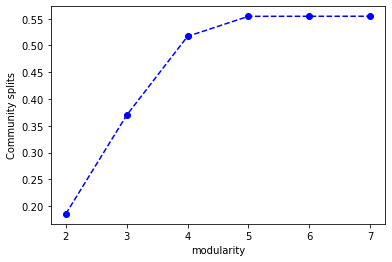

In [31]:
fig, ax = plt.subplots();
ax.plot(community_splits, community_modularities, linestyle='--', marker='o', color='b', label='modularity')
# plt.legend()
ax.set_xlabel("modularity")
ax.set_ylabel("Community splits");

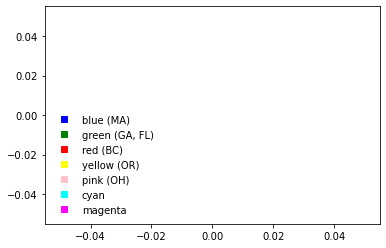

In [27]:
# make legend for split 7
import matplotlib.pyplot as plt
# 285 blue {'MA': 272, 'GA': 4, 'OR': 4, 'FL': 3, 'BC': 2} {False: 279, True: 6}
# 659 green {'GA': 318, 'FL': 263, 'VA': 46, 'MA': 15, 'OR': 14, 'OH': 3} {False: 645, True: 14}
# 178 red {'BC': 171, 'OR': 5, 'GA': 2} {True: 176, False: 2}
# 241 yellow {'OR': 235, 'MA': 3, 'BC': 2, 'OH': 1} {True: 237, False: 4}
#115 pink {'OH': 99, 'GA': 6, 'FL': 5, 'MA': 3, 'VA': 1, 'OR': 1} {False: 114, True: 1}
#2 cyan {'GA': 2} {False: 2}
#2 magenta {'GA': 2} {False: 2
colors = ["blue", "green", "red","yellow","pink","cyan","magenta"]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(7)]
labels = ["blue (MA)", "green (GA, FL)", "red (BC)","yellow (OR)","pink (OH)","cyan","magenta"]
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False)

fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

plt.show()